<a href="https://colab.research.google.com/github/thinzaroo/faceMaskClassification/blob/main/face_mask_image_classification_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import necessary packages and libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

#Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [3]:
#mount google drive
from google.colab import drive
drive.mount("/content/gdrive") 

Mounted at /content/gdrive


In [4]:
#count the number of files in folder (my dataset in Google Drive)

DIR_WITH_MASK = '/content/gdrive/My Drive/ML_assignment_data/with_mask'
DIR_WITHOUT_MASK = '/content/gdrive/My Drive/ML_assignment_data/without_mask'
num_files_with_mask = len(os.listdir(DIR_WITH_MASK))
num_files_without_mask = len(os.listdir(DIR_WITHOUT_MASK))
print(num_files_with_mask)
print(num_files_without_mask)

3725
3828


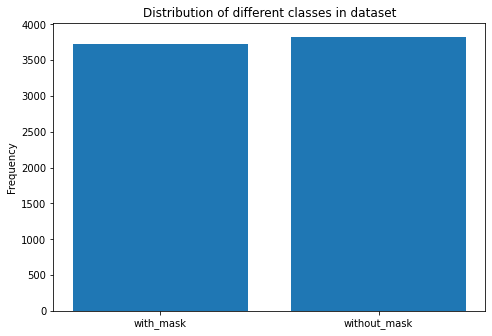

In [ ]:
#plot the classification of dataset

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['with_mask', 'without_mask']
frequency = [num_files_with_mask,num_files_without_mask]
ax.bar(classes,frequency)
ax.set_ylabel('Frequency')
ax.set_title('Distribution of different classes in dataset')
plt.show()

In [5]:
#convert the files to dataframe

filepaths = []
labels= []
dict_list = [DIR_WITH_MASK, DIR_WITHOUT_MASK]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('with_mask')
        else:
          labels.append('without_mask') 
    
FileSeries = pd.Series(filepaths, name="filepaths")
LabelSeries = pd.Series(labels, name="labels")
mask_data = pd.concat([FileSeries,LabelSeries], axis=1)
mask_df = pd.DataFrame(mask_data)
print(mask_df.head())
print(mask_df["labels"].value_counts())

                                           filepaths     labels
0  /content/gdrive/My Drive/ML_assignment_data/wi...  with_mask
1  /content/gdrive/My Drive/ML_assignment_data/wi...  with_mask
2  /content/gdrive/My Drive/ML_assignment_data/wi...  with_mask
3  /content/gdrive/My Drive/ML_assignment_data/wi...  with_mask
4  /content/gdrive/My Drive/ML_assignment_data/wi...  with_mask
without_mask    3828
with_mask       3725
Name: labels, dtype: int64


In [6]:
#shape of datatset
mask_df.shape

(7553, 2)

In [7]:
#train-test split

train_set, test_images = train_test_split(mask_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.2, random_state=42)

In [8]:
# Data Pre-processing, resize images and convert to grayscale
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='grayscale',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='grayscale',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'grayscale',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 5287 validated image filenames belonging to 2 classes.
Found 1812 validated image filenames belonging to 2 classes.
Found 454 validated image filenames belonging to 2 classes.


In [9]:
classes=list(train.class_indices.keys())
print (classes)

['with_mask', 'without_mask']


In [10]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

# Model #1

In [11]:
import keras
from tensorflow.keras import layers

CNN_1 = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(244,244,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

CNN_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
CNN_1.optimizer.lr=0.001

CNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0

In [12]:
history_CNN = CNN_1.fit(train, validation_data= val, epochs=15,verbose=1)

Epoch 1/15
166/166 [==============================] - 786s 5s/step - loss: 0.5683 - accuracy: 0.7047 - val_loss: 0.4226 - val_accuracy: 0.8062
Epoch 2/15
166/166 [==============================] - 464s 3s/step - loss: 0.3693 - accuracy: 0.8387 - val_loss: 0.2962 - val_accuracy: 0.8744
Epoch 3/15
166/166 [==============================] - 461s 3s/step - loss: 0.2672 - accuracy: 0.8911 - val_loss: 0.2375 - val_accuracy: 0.8899
Epoch 4/15
166/166 [==============================] - 466s 3s/step - loss: 0.2065 - accuracy: 0.9181 - val_loss: 0.2514 - val_accuracy: 0.8943
Epoch 5/15
166/166 [==============================] - 459s 3s/step - loss: 0.1524 - accuracy: 0.9408 - val_loss: 0.2260 - val_accuracy: 0.8987
Epoch 6/15
166/166 [==============================] - 463s 3s/step - loss: 0.1141 - accuracy: 0.9533 - val_loss: 0.1974 - val_accuracy: 0.9295
Epoch 7/15
166/166 [==============================] - 467s 3s/step - loss: 0.0971 - accuracy: 0.9590 - val_loss: 0.3463 - val_accuracy: 0.8877

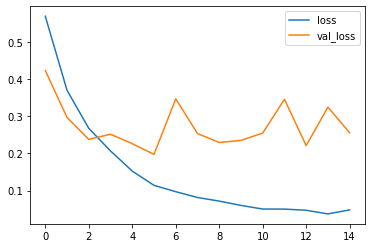

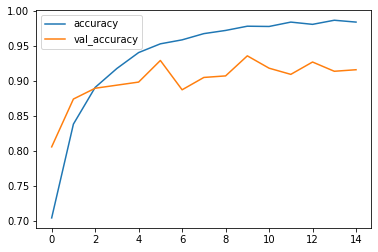

In [13]:
#resuts from model 1
plot_loss_and_accuracy(history_CNN.history)

detect overfitting in model 1

In [15]:
pred = CNN_1.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

   with_mask       0.91      0.91      0.91       889
without_mask       0.92      0.92      0.92       923

    accuracy                           0.92      1812
   macro avg       0.91      0.92      0.91      1812
weighted avg       0.92      0.92      0.92      1812



# Model #2

In [17]:
from tensorflow.keras import layers

cnnModel2 = tf.keras.models.Sequential([
  layers.Conv2D(32, 3, activation='relu',input_shape=(244,244,1)),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

cnnModel2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnnModel2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 242, 242, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 121, 121, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 119, 119, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

In [18]:
#train model 2 for 15 epochs
history_m2_CNN = cnnModel2.fit(train, validation_data= val, epochs=15,verbose=1)

Epoch 1/15
166/166 [==============================] - 557s 3s/step - loss: 0.6594 - accuracy: 0.5854 - val_loss: 0.6278 - val_accuracy: 0.6189
Epoch 2/15
166/166 [==============================] - 553s 3s/step - loss: 0.6152 - accuracy: 0.6461 - val_loss: 0.6068 - val_accuracy: 0.6542
Epoch 3/15
166/166 [==============================] - 550s 3s/step - loss: 0.5840 - accuracy: 0.6830 - val_loss: 0.5365 - val_accuracy: 0.7357
Epoch 4/15
166/166 [==============================] - 561s 3s/step - loss: 0.4822 - accuracy: 0.7753 - val_loss: 0.4311 - val_accuracy: 0.8018
Epoch 5/15
166/166 [==============================] - 551s 3s/step - loss: 0.4194 - accuracy: 0.8152 - val_loss: 0.3686 - val_accuracy: 0.8392
Epoch 6/15
166/166 [==============================] - 553s 3s/step - loss: 0.3684 - accuracy: 0.8470 - val_loss: 0.3366 - val_accuracy: 0.8502
Epoch 7/15
166/166 [==============================] - 557s 3s/step - loss: 0.3443 - accuracy: 0.8587 - val_loss: 0.3136 - val_accuracy: 0.8678

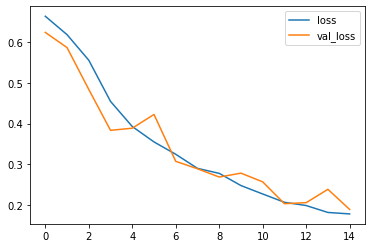

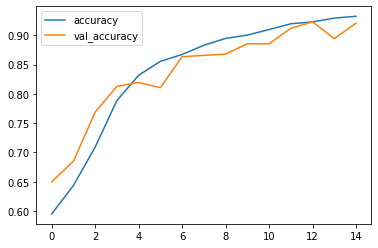

In [ ]:
plot_loss_and_accuracy(history_m2_CNN.history)

Overcome overfitting compare to model 1, but does not improve accuracy much.

# Confustion Matrix

In [22]:
pred_mod2 = cnnModel2.predict(test)
pred_mod2 = np.argmax(pred_mod2, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2_mod2 = [labels[k] for k in pred_mod2]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2_mod2))

              precision    recall  f1-score   support

   with_mask       0.91      0.91      0.91       889
without_mask       0.91      0.92      0.92       923

    accuracy                           0.91      1812
   macro avg       0.91      0.91      0.91      1812
weighted avg       0.91      0.91      0.91      1812



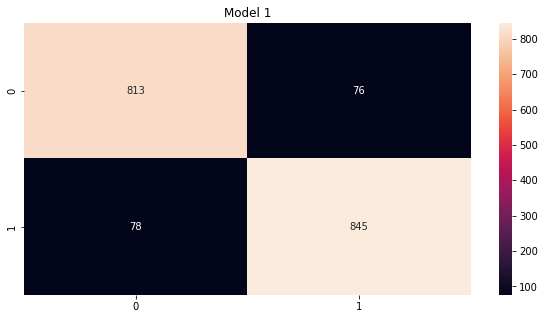

In [20]:
# model 1
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
ax = plt.axes()
cm = confusion_matrix(y_test, pred2)
ax.set_title('Model 1')
sns.heatmap(cm, annot=True, fmt = 'g', ax=ax)

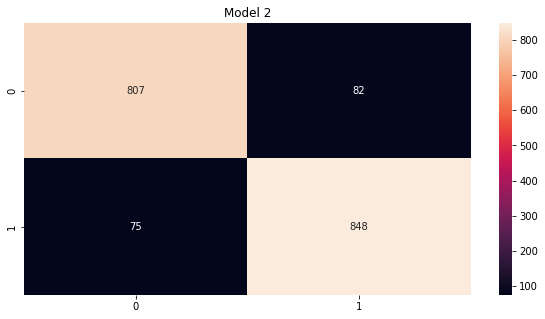

In [24]:
# model 2
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
ax = plt.axes()
cm = confusion_matrix(y_test, pred2_mod2)
ax.set_title('Model 2')
sns.heatmap(cm, annot=True, fmt = 'g', ax=ax)

In [26]:
print("Model1 Accuracy:" + str(accuracy_score(y_test, pred2)))
print("Model2 Accuracy:" + str(accuracy_score(y_test, pred2_mod2)))

Model1 Accuracy:0.9150110375275938
Model2 Accuracy:0.9133554083885209
